## Finding latent topics in a Movie
The idéa of this experiment is to see if Topic Modeling can be used to find latent topics in movies.
Two different topic models will be used, LDA and LSI. 
A large database of movie summaries will be used to fit the model. 
There exist several steps that have to be executed before we can start fitting data to the model.
Existing implementations of the above topic models will be used in this experiment (gensim).

## Pre-processing

### 1. Importing neccessary libraries

In [1]:
import os
from gensim import models
import nltk
from nltk.tag.perceptron import PerceptronTagger
import time
import pickle
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer
wordnet_lemmatizer = WordNetLemmatizer()
from gensim import corpora
from pprint import pprint
from collections import defaultdict
import operator
from collections import namedtuple
from gensim.models import CoherenceModel
from gensim.corpora import Dictionary
import matplotlib.pyplot as plt

C:\Users\Dator\Anaconda3\lib\site-packages\gensim\utils.py:840: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")
C:\Users\Dator\Anaconda3\lib\site-packages\gensim\utils.py:1015: UserWarning: Pattern library is not installed, lemmatization won't be available.
  warnings.warn("Pattern library is not installed, lemmatization won't be available.")


### 2. Loading data
Loading the data. Each line of the summaries document consist of a summary. Each line will be stripped of special characters and numbers.

In [2]:
# Used for loading CMU movie summary dataset
def load_data(file_path):
    # Loading the data
    file = open(file_path, "r", encoding="utf-8")
    documents = []
    document_count = 42305
    # Read line for line (each line is a summary)
    for index, line in enumerate(file):
        if(index == document_count):
            break
        # Remove all special characters / numbers from the summary
        line = line.translate({ord(c): None for c in '!@#$%^&*()[]{};:,./<>?\|`~-=_+",0123456789\''}).strip()  
        documents.append(line)
    print("Loaded",len(documents),"summaries")
    #print(documents[1])
    return documents


In [3]:
# User for loading the OPUS subtitle dataset
def load_subtitles(nbr_of_subsets):
    # Open 1 subset file (holds 1500 subtitles) | TODO: Run through more subtitle sets
    list_of_subsets = os.listdir("Subtitles")
    # Intialize a new list of documents (subtitles)
    list_of_subtitles = []
    for subset in range(0, nbr_of_subsets):    
        file = open("Subtitles" + os.path.sep + list_of_subsets[subset], "r", encoding="utf8")
        subtitle = ""
        # Read each line of the subset file.
        for line in file:
            # If line is a subtitle break line (meaning that we reached the end of 1 subtitle)
            if line == "!!!\n":
                # Append the stored subtitle (subtitle variable) in the list of subtitles and start to read a new subtitle
                list_of_subtitles.append(subtitle)
                subtitle = ""
                continue
            else:
                # Remove special characters and numbers
                line = line.translate({ord(c): None for c in '!@#$%^&*()[]{};:,./<>?\|`~-=_+",0123456789\''})
                # Remove line break characters
                line = line.replace("\n", "")
                subtitle += line
        file.close()
        # When finished, the Documents list should contain 1500 elements. len(documents) == 1500
        print("Number of subtitles read: " + str(len(list_of_subtitles))) 
    return list_of_subtitles  

### 3. Loading stopwords
Stopwords are words which are considered to provide no direct meaning to the movie. Words like is, are, this, that as well as names that would confuse our topic models resultning in topics of names (since there are A LOT of names in movies).

In [4]:
def load_stopwords():
    # Loading stop-words from file
    stopwords_file = open("stopwords.txt", "r")
    stopwords = []
    for line in stopwords_file:
        stopwords.append(line.replace("\n", "").lower())
    stopwords_file.close()
    # Convert to a set. Since python sets are a lot faster then lists when it comes to finding unique items.
    stopwords = set(stopwords)
    print("Finished loading stop-words")
    return stopwords

### 4. Part-of-Speech tagging
Part-of-speech tagging enables us to remove words that are not nouns. Nouns are considered to give the most thematic meaning. Adverds and adjectives may not provide as much thematic meaning.
Two functions are provided below, pos_tag_documents is used when transforming data to fit the model. pos_tag_documents in itself uses pos_tag to actually tag documents. pos_tag by itself is used when POS-tagging test documents in a later stage when we want to test our trained model. 

In [5]:
def pos_tag(documents):
    start_time = time.time()
    # Vectorize, POS-tag -> Keep only nouns
    tagger = PerceptronTagger()
    # For each document in documents. 
    for index, doc in enumerate(documents):
        # Tokenize the words
        words = nltk.word_tokenize(doc)
        # POS-tag each word
        documents[index] = tagger.tag(words)
    seconds = time.time() - start_time
    m, s = divmod(seconds, 60)
    print("Pos-tagging took ", m, ":", s , " seconds")
    return documents

In [6]:
def pos_tag_documents(documents):
    file_name = "pos_tagged_corpus.corp" + str(len(documents))
    if os.path.isfile(file_name):
        file = open(file_name, "rb")
        documents = pickle.load(file)
    else:
        documents = pos_tag(documents)
        # Store POS-tagged file
        pos_file = open(file_name, "wb")
        pickle.dump(documents, pos_file)
        pos_file.close()
    return documents

### 5. Trimming stopwords/keeping nouns and lemmatization
remove_nouns_stopwords is the function that removes both stopwords and anything that isn't a noun. It will used get_wordnet_pos to transform TreeBank-tags (returned by the lemmatizer method) to Wordnet tags that are easier to use.
Lemmatization is the process of finding a words "base". For example, soldiers would become soldier, writing would become write.
This reduces the dimentions of our document as well as increase weights of words that appear in different forms. 

In [7]:
def get_wordnet_pos(treebank_tag):
    if treebank_tag.startswith('J'):
        return wordnet.ADJ
    elif treebank_tag.startswith('V'):
        return wordnet.VERB
    elif treebank_tag == 'NN':
        return wordnet.NOUN
    elif treebank_tag == 'NNS':
        return wordnet.NOUN
    elif treebank_tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.ADJ    

In [8]:
def remove_nouns_stopwords(documents, stopwords):
    start_time = time.time()
    
    for doc_index, doc in enumerate(documents):
        trimmed_words = []
        for word_index, word in enumerate(doc):
            if get_wordnet_pos(word[1]) == wordnet.NOUN:
                    #del documents[doc_index][word_index]
                    if word[0].lower() not in stopwords and len(word) > 1:
                        #stemmed_word = stemmer.stem(word[0].lower())
                        lemma = wordnet_lemmatizer.lemmatize(word[0], pos=get_wordnet_pos(word[1])).lower()
                        trimmed_words.append(lemma)
        documents[doc_index] = trimmed_words
    #print(documents[1])
    seconds = time.time() - start_time
    m, s = divmod(seconds, 60)
    print("POS-trimming took ", m, ":", s , " seconds")
    return documents

### 6. Pruning unneccessary words
Another step to reduce dimensionality is to prune words that only exist in a few documents as well as words that exist in too many documents. 

In [9]:
def prune_documents(documents, lowest_freq, highest_freq):
    dictionary = corpora.Dictionary(documents)
    #dictionary.save('subtitles.dict')  # store the dictionary, for future reference
    print(dictionary)
    # Prune the dictionary
    #dictionary.filter_extremes(no_below=5, no_above=0.10)
    dictionary.filter_extremes(no_below=lowest_freq, no_above=highest_freq)
    
    print("Pruned dict: ", dictionary)
    #pprint(dictionary.token2id)
    return dictionary

### 7. Formatting documents before fitting to model
Formatting the data is required to be able to fit the two different models. 
Every document will be transformed into a bag-of-words. A BOW is basically a list of frequencies. How often a word occur in the document. 
A corpus, is a list of BOW's. 

In [10]:
def convert_to_corpus(documents, dictionary):
    corpus = [dictionary.doc2bow(doc) for doc in documents]
    # Store to disc for later use
    #corpora.MmCorpus.serialize('subtitles.mm', corpus) 
    print("Created a corpus of bag-of-words")
    return corpus

## Training the topic models
LSI: this model will first transform our corpus of bow's to a corpus of TF-IDF (term frequency, inverse document frequency). TF-IDF is a way of lowering the weights of words that appear frequently across the corpus. Thus, resulting in unique words getting a higher weight. 
LDA: only requires our prepared Corpus of bow's. This gensim LDA implementation is using multiple CPU cores resulting in a MUCH faster training time. There are multiple parameters that can be tweaked to improve the coherence of the topics. The most important ones are, the number of passes that the LDA algorithm will do over the corpus as well as the number of topics we want it to find. 

In [11]:
def lsi(corpus, topics):
    print("Running LSI...")
    tfidf = models.TfidfModel(corpus)
    corpus_tfidf = tfidf[corpus]
    #for i in range(0,10):
    #    print(corpus_tfidf[i])
    start = time.time()
    lsi = models.LsiModel(corpus_tfidf, id2word=dictionary, num_topics=topics)
    end = time.time()
    print("Training finished.. It took: ", end - start, " seconds")
    #corpus_lsi = lsi[corpus_tfidf]
    #pprint(lsi.print_topics(10))
    return lsi


In [40]:
import logging
#logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

def lda_multicore(corpus, dictionary, topics, passes, iterations):
    print("Running LDA...")
    start = time.time()
    #lda = models.LdaMulticore(corpus, id2word=dictionary, num_topics=50, workers=3, passes=100)
    lda = models.LdaMulticore(corpus, id2word=dictionary, num_topics=topics, passes=passes, iterations=iterations)
    end = time.time()
    print("Training finished.. It took: ", end - start, " seconds")
    return lda

### Training

In [13]:
def train(algo, topics, passes, iterations):
    model = None
    if algo.lower() == "lda":
        # Run LDA in multicore setup. 
        model = lda_multicore(corpus, dictionary, topics, passes, iterations)
        # Print topics with there respective highest relevance words.
        pprint(model.print_topics(-1))
    else:
        # Run LSI
        model = lsi(corpus, topics)
        model.print_topics(-1)
    return model
    

## Testing
To test the model we can simply use our model to infer latent topics on new documents. We will then examine the resulting topics. The test document requires some preprocessing as well before we use it on the model.

In [14]:
def lda_testing(bow):  
    # Use existing LDA model to infer topics on this new document
    topics = model[bow]
    print("\n")
    # Sort the infered topics
    sorted_topics = list(sorted(topics, key=lambda x: x[1], reverse=True))
    # Print the topic names and the top 6 words for each topic
    for topic in sorted_topics:
        print("\nProb: ", topic[1], " : \n", model.print_topic(topic[0], 6))

def lsi_testing(bow):
    tfidf_score = model[bow]
    #print(tfidf_score)
    data = model[tfidf_score]
    data_sorted = sorted(data, key=lambda x: x[1], reverse=True)
    for doc in data_sorted:
        pprint(model.print_topic(doc[0]))        
        
def run_test(algo, file_path):
    # Loading the test-data
    test_documents = load_data(file_path)
    for doc in test_documents:
        print("\n\nDocument:\n", doc, "\n")
        # POS-tag*
        test_doc = []
        test_doc.append(doc)
        test_doc_tagged = pos_tag(test_doc)
        print("\n\nPOS-tagged:\n", test_doc_tagged )
        # Remove stopwords etc
        clean_test_doc = remove_nouns_stopwords(test_doc_tagged, stopwords)
        print("\n\nCleaned:\n", clean_test_doc[0], "\n" )        
        # Convert to bag-of-words
        bow = dictionary.doc2bow(clean_test_doc[0])        
        if algo.lower() == "lda":
            lda_testing(bow)
        else:
            lsi_testing(bow)

### Running pre-processing
This section will run the above defined functions to preprocess the data, making it available for use in evaluation and testing

In [78]:
# Loading the data into a list of documents
documents = load_data("plot_summaries.txt") # Loads the CMU summaries
#documents = load_subtitles(5) # Loads the OPUS subtitle corpus

# Loading stopwords 
stopwords = load_stopwords()
# Part-of-speech tagging every word in each document
tagged_documents = pos_tag_documents(documents)
# Remove every word that appears in stopwords or/and is NOT a noun
clean_documents = remove_nouns_stopwords(tagged_documents, stopwords)
# Prune the list of documents and remove elements that appear in less then 5 documents and in more then 10% of the documents.
dictionary = prune_documents(clean_documents, 5, 0.6)
# Convert the list of documents into a corpus (basically a list of bag-of-words)
corpus = convert_to_corpus(clean_documents, dictionary)

Loaded 42305 summaries
Finished loading stop-words
POS-trimming took  0.0 : 20.516443729400635  seconds
Dictionary(51909 unique tokens: ['love—without', 'selfdeprecation', '“clients”', 'motherinlaw’s', 'sister—and']...)
Pruned dict:  Dictionary(13749 unique tokens: ['unites', 'trapeze', 'cofounder', 'chisel', 'reconnaissance']...)
Created a corpus of bag-of-words


## Evaluation
#### NOTE: RUN WITH CARE!!
All the methods below this mark until LDA execution (last step) is used to evalute different models to find different optimal parameters. This take a considerable amount of time, in total in has taken a i7 4790k intel CPU approx 6-8 hours running on all cores to produce this results. Also note that, running evalution multiple times most likely yields different results each time. Should however, be similar.

The below method is needed for the evalution and graph printing code below to function properly. Only the dictionary object gets pruned in the pruning step above which is the only one needing pruning before the corpus is created. However, the evaluation functions below require that the "texts" is of the same length as the corpus. The below method essentially copies all the unique words from the dictionary. It will take some time. Could most likely be improved for better performance. 

In [ ]:
dict_list = []
for val in dictionary.itervalues():
    dict_list.append(val)
print("Values: ", len(dict_list))
    
print("Running cleaning")
start = time.time()
texts = []
for i, doc in enumerate(clean_documents):
    text = []
    for word_idx, word in enumerate(clean_documents[i]):
        if word in dict_list:
            #del clean_documents[i][word_idx]
            text.append(word)
    if(len(text) > 0):
        texts.append(text)
end = time.time()
print("Cleaning finished.. It took: ", end - start, " seconds")
print(str(texts))

### Methods for evaluating topics, passes and iterations
This code is borrowed from https://gist.github.com/dsquareindia/ac9d3bf57579d02302f9655db8dfdd55 and I have only customized it to my needs. Therefore I take no credit for this code. 

In [50]:
%matplotlib inline

def evaluate_topics(dictionary, corpus, texts, f_limit, t_limit):
    c_v = []
    lm_list = []
    for num_topics in range(f_limit, t_limit):
        lm = models.LdaMulticore(corpus=corpus, num_topics=num_topics, id2word=dictionary, passes=25, iterations=50)
        lm_list.append(lm)
        cm = CoherenceModel(model=lm, texts=texts, dictionary=dictionary, coherence='c_v')
        c_v.append(cm.get_coherence())
        
    # Show graph
    x = range(f_limit, t_limit)
    plt.plot(x, c_v)
    plt.xlabel("num_topics")
    plt.ylabel("Coherence score")
    plt.legend(("cv"), loc='best')
    plt.show()   
    return lm_list


In [62]:
%matplotlib inline

def evalutate_passes(dictionary, corpus, texts, f_limit, t_limit, step):
    c_v = []
    lm_list = []
    for num_passes in range(f_limit, t_limit, step):
        lm = models.LdaMulticore(corpus=corpus, num_topics=56, id2word=dictionary, passes=num_passes)
        lm_list.append(lm)
        cm = CoherenceModel(model=lm, texts=texts, dictionary=dictionary, coherence='c_v')
        c_v.append(cm.get_coherence())
        print(num_passes, " done..")
        
    # Show graph
    x = range(f_limit, t_limit, step)
    plt.plot(x, c_v)
    plt.xlabel("num_passes")
    plt.ylabel("Coherence score")
    plt.legend(("cv"), loc='best')
    plt.show()
    
    return lm_list


In [69]:
%matplotlib inline

def evalutate_iterations(dictionary, corpus, texts, f_limit, t_limit, step):
    c_v = []
    lm_list = []
    for num_iterations in range(f_limit, t_limit, step):
        lm = models.LdaMulticore(corpus=corpus, num_topics=56, id2word=dictionary, passes=25, iterations=num_iterations)
        lm_list.append(lm)
        cm = CoherenceModel(model=lm, texts=texts, dictionary=dictionary, coherence='c_v')
        c_v.append(cm.get_coherence())
        print(num_iterations, " done..")
        
    # Show graph
    x = range(f_limit, t_limit, step)
    plt.plot(x, c_v)
    plt.xlabel("num_iterations")
    plt.ylabel("Coherence score")
    plt.legend(("cv"), loc='best')
    plt.show()
    
    return lm_list

### Running the evaluation steps
These are not necessary unless evaluation has to be done. These steps will take an considerable amount of time. LDA can be executed without these evaluation steps. Just run the last step and enter the parameters.

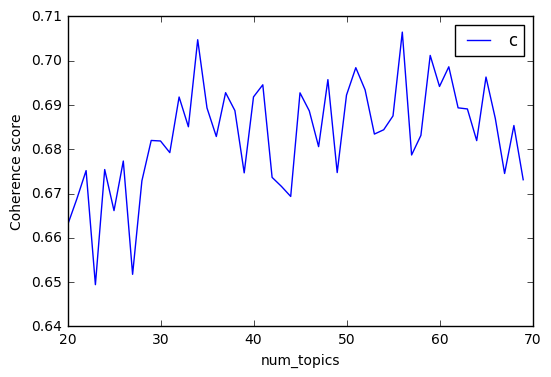

In [48]:
# Topics
# Running coherence test for models ranging from 20 - 70 topics. 15 passes and 50 iterations were used.
lm_list = evaluate_topics(dictionary, corpus, texts, 20, 70)

10  done..
15  done..
20  done..
25  done..
30  done..
35  done..
40  done..
45  done..
50  done..
55  done..
60  done..
65  done..
70  done..
75  done..
80  done..
85  done..
90  done..
95  done..


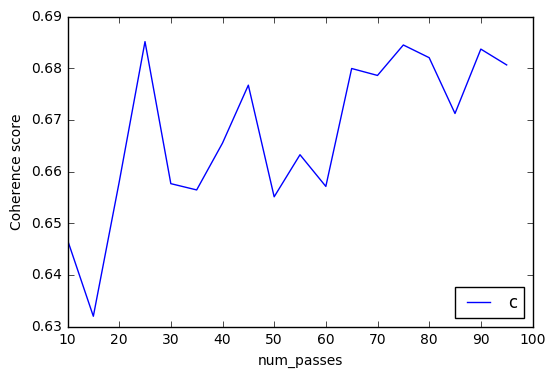

In [64]:
# Evaluate Passes
# Method to trigger the passes evaluation function.
lm_list_passes = evalutate_passes(dictionary, corpus, texts, 10, 100, 5)

10  done..
60  done..
110  done..
160  done..


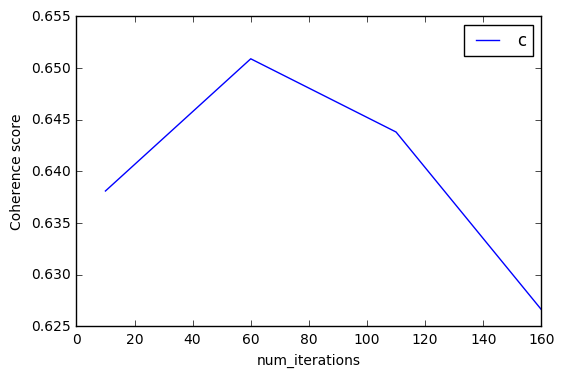

In [70]:
# Evalute iterations
# Trigger function to evalute iterations, ranging from 10-210 in steps of 50. 56 topics and 25 passes are set.
lm_list_passes = evalutate_iterations(dictionary, corpus, texts, 10, 210, 50)

### Executing the model
This step is executed to train the model and after that it will test the model by inferring topics on the test data.
Both the topics and the inferred testing data topics will be printed in the output. Executing the LDA training could take some time depending on the CPU. Takes about 20min on an i7 4790k with 4 hyperthreaded (basically 8) cores. LDA is set to use all available CPU to train essentially maxing out the CPU at 100%. Use with care.

In [79]:
# Train the model. Set it too 56 topics, 25 passes and 60 iterations.
# Train method takes as input: "algorithm", "number of topics", "number of passes" and "number of iterations". 
# Note that you probably will have to enter passes and iterations if "lsi" is specified even though they are not used. 
model = train("lda", 56, 25, 60)

# Run the test data
run_test("lda", "TestData\Summaries\documents.txt")

Running LDA...
Training finished.. It took:  629.9285457134247  seconds
[(0,
  '0.041*"doctor" + 0.040*"hospital" + 0.027*"life" + 0.024*"relationship" + '
  '0.023*"daughter" + 0.019*"time" + 0.016*"marriage" + 0.016*"parent" + '
  '0.016*"patient" + 0.014*"year"'),
 (1,
  '0.127*"train" + 0.067*"station" + 0.047*"bus" + 0.041*"driver" + '
  '0.024*"car" + 0.019*"passenger" + 0.015*"taxi" + 0.012*"track" + '
  '0.011*"railway" + 0.011*"board"'),
 (2,
  '0.037*"letter" + 0.037*"job" + 0.027*"relationship" + 0.024*"life" + '
  '0.022*"company" + 0.021*"friend" + 0.019*"store" + 0.017*"boyfriend" + '
  '0.017*"time" + 0.015*"woman"'),
 (3,
  '0.064*"time" + 0.023*"bank" + 0.020*"diamond" + 0.018*"memory" + '
  '0.012*"future" + 0.011*"vault" + 0.009*"travel" + 0.009*"security" + '
  '0.008*"order" + 0.007*"number"'),
 (4,
  '0.034*"body" + 0.029*"room" + 0.018*"death" + 0.014*"head" + 0.012*"face" + '
  '0.012*"hand" + 0.011*"hospital" + 0.010*"knife" + 0.008*"demon" + '
  '0.008*"doll"'